# CNN face detecting

<a href="https://colab.research.google.com/github/rohitd3/manyFacesML/blob/master/_notebooks/CNN_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision
!pip install torchviz
!pip install --upgrade torch torchvision
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import helper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=5b653ed5695989f3eff83b69b1958232039f5053c50385f0aa74417b6c5e6b0c
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()

In [1]:
from google.colab import drive
from google.colab import files
from PIL import Image

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
data_directory_face = '/content/gdrive/MyDrive/FACEML/face'

In [3]:
############  These values can be changed for the Model and tested ############
# Keep the Image width, height a multiple of 4.
#This will ensure after Conv2D with 5X5 filter, and MaxPool(2,2) TWICE,
# the values height2, width2 are still integers
ImageWidth=384
ImageHeight=384

#the most common choices for convolution filter kernel sizes appear to be square shape of sizes 3X3, 5X5
#smaller sized kernel allows for more granular information. Here 5X5 is used.
#Maxpool is needed when the image is larger. It keeps the item with the maximum value.

convKernelSize1 =5
convKernelSize2 =5
maxpoolKernelSize = 2

#conv1 Input Channel is default 3 for R, G, B channels directly from the colored Image
convOutputChannel1 = 16
#convInputChannel2 is the same as the convOutputChannel1
convOutputChannel2 = 32
linearOut1 = 256
linearOut2 = 84

dropOutValue = 0.2

# for the first convolution and max pool
height1=int((ImageHeight - convKernelSize1 + 1)/maxpoolKernelSize) 
width1=int((ImageWidth - convKernelSize1 + 1)/maxpoolKernelSize)

# for the second convolution and max pool
height2=int((height1 - convKernelSize2 + 1)/maxpoolKernelSize) 
width2=int((width1 - convKernelSize2 + 1)/maxpoolKernelSize)

print(" ImageWidth = ", ImageWidth)
print(" ImageHeight = ", ImageHeight)
print(" width1 = ", width1)
print(" height1 = ", height1)
print(" width2 = ", width2)
print(" height2 = ", height2)

 ImageWidth =  384
 ImageHeight =  384
 width1 =  190
 height1 =  190
 width2 =  93
 height2 =  93


In [4]:
import torch
import torchvision
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
test_size = 0.3
valid_size = 0.1


# Preprocessing steps
# Horizontal Flip, Random Rotation, convert image array into PyTorch and normalize
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(60),
    transforms.Resize(size=(ImageWidth,ImageHeight)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # need to keep these transforms, at least do resize all images to same size and co
    ])


In [5]:
data = datasets.ImageFolder(data_directory_face,transform=train_transform) 
plt.show(data)

The data needs to be split in Train, Test and validation set before training.
 - Train set will be used to train the model.
 - Validation set will be used for validating the model after each epoch. 
 - Test set will be used to evaluate the model once it is trained.


In [6]:
num_data = len(data)
print("num_data = ", num_data)

indices_data = list(range(num_data))
np.random.shuffle(indices_data)

#For test and training

split_tt = int(np.floor(test_size * num_data))

# numpy.floor function operates element-wise on the input array, 
# returning a new array with the same shape as the input. 
# It rounds down each element of the input array to the nearest 
# integer that is less than or equal to that element

train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

print("\n train_idx = ", train_idx)
print("\n test_idx = ", test_idx)

#From training separate data For validation (for each epoch)
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

print("\n train_new_idx = ", train_new_idx)
print("\n valid_idx = ", valid_idx)

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

num_data =  400

 train_idx =  [116, 324, 9, 382, 41, 161, 124, 270, 91, 95, 317, 212, 191, 149, 182, 381, 23, 389, 289, 273, 14, 29, 38, 329, 143, 374, 165, 283, 272, 198, 362, 248, 333, 208, 130, 22, 215, 90, 121, 373, 35, 237, 81, 276, 59, 86, 326, 163, 391, 213, 109, 316, 218, 122, 278, 348, 205, 137, 64, 185, 364, 74, 159, 87, 233, 245, 269, 68, 220, 129, 390, 263, 45, 285, 378, 211, 175, 48, 134, 231, 249, 13, 98, 167, 335, 1, 78, 94, 258, 10, 223, 266, 103, 25, 52, 352, 99, 79, 318, 111, 202, 49, 2, 357, 113, 397, 82, 290, 292, 18, 291, 203, 58, 301, 346, 148, 31, 229, 54, 385, 75, 235, 179, 300, 246, 396, 243, 62, 189, 4, 30, 236, 5, 294, 138, 19, 112, 206, 158, 196, 70, 197, 287, 114, 370, 16, 101, 105, 394, 334, 343, 110, 193, 377, 363, 277, 65, 43, 367, 242, 24, 279, 8, 252, 195, 108, 88, 107, 133, 20, 77, 102, 47, 186, 251, 66, 217, 274, 26, 60, 150, 388, 187, 126, 310, 34, 319, 254, 312, 178, 42, 244, 154, 311, 267, 349, 341, 264, 238, 224, 92, 100, 96, 40, 308, 359, 353, 

In [7]:
# Loaders contains the data in tuple format (Image in form of tensor, label)
# train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler=train_sampler, num_workers=1, transform=train_transform)
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler=train_sampler, num_workers=1)

# only running the data augmentation on the training data, double check if works
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(data, sampler = test_sampler, batch_size=batch_size, num_workers=1)

# variable representing classes of the images
classes = [0,1] # labeling either 0 (negative) or 1 (positive)

total_length = len(test_loader)*batch_size + len(valid_loader)*batch_size + len(train_loader)*batch_size
print("total_length = ", total_length)

total_length =  416


In [8]:
for batch in valid_loader:
    print("batch[0].size() = ", batch[0].size())

batch[0].size() =  torch.Size([16, 3, 384, 384])
batch[0].size() =  torch.Size([12, 3, 384, 384])


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def imshownormal(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshownormal(np.transpose(img, (0, 0, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels


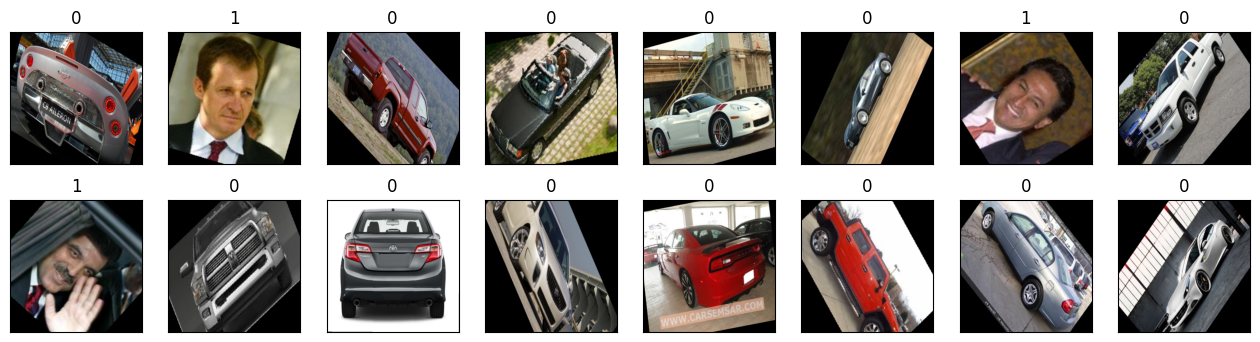

None

In [10]:
num_of_image_to_display = 16

fig = plt.figure(figsize=(num_of_image_to_display, 4))

for idx in np.arange(num_of_image_to_display):
    ax = fig.add_subplot(2, int(num_of_image_to_display/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

display(plt.show())
plt.close()

In [11]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
from torch.autograd import Variable

# What is pytorch?
PyTorch is an open-source machine learning library primarily used for deep learning tasks. It is developed by Facebook's AI Research Lab and provides a Python interface for building and training neural networks. PyTorch is known for its dynamic computational graph, which allows users to define and modify computational graphs on-the-fly during runtime.

Neural network building blocks: PyTorch provides a rich set of pre-built modules and classes for building neural networks, such as various types of layers (e.g., fully connected, convolutional, recurrent), activation functions, loss functions, and optimizers.

GPU acceleration: PyTorch seamlessly integrates with CUDA, a parallel computing platform, to leverage the power of NVIDIA GPUs for faster training and inference.

In [12]:
## Start training

import torch.nn as nn
import torch.nn.functional as F
train_on_gpu = torch.cuda.is_available()
print("train_on_gpu = ", train_on_gpu)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # define the two convolutional operations
        # conv1 Input Channel =3 for the R, G, B channels directly from the Image
        self.conv1 = nn.Conv2d(3, convOutputChannel1, convKernelSize1)
        self.conv2 = nn.Conv2d(convOutputChannel1, convOutputChannel2, convKernelSize2)

        # define the max pool operation
        self.pool = nn.MaxPool2d(maxpoolKernelSize, maxpoolKernelSize)        
        
        self.dropout = nn.Dropout(dropOutValue)
         
        # define the Linear (fully connected) operations 
        self.fc1 = nn.Linear(convOutputChannel2* height2 * width2, linearOut1)
        self.fc2 = nn.Linear(linearOut1, linearOut2)
        self.fc3 = nn.Linear(linearOut2, 2)
        self.softmax = nn.LogSoftmax(dim=1)
  
    def forward(self, x):
        # add sequence of convolutional, relu and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        # the linearization needs to start with = # of output channels * height2 * width2
        x = x.view(-1, convOutputChannel2 * height2 * width2)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

train_on_gpu =  True


# Training the Model
 Finally comes the training part. Here you need to decide two crucial things: Loss function and optimizer. 
 There are various choices like SGD, Adam, etc.. for the optimizer.
 used Cross-Entropy loss, which is a popular choice in the case of classification problems.
 should also set a learning rate, which decides how fast your model learns.

In [13]:
# create a complete CNN
model = Net()
print("++++++++++++ print the model ++++++++")
print(model)
print("+++++++++++++++++++++++++++++++++++++")

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

++++++++++++ print the model ++++++++
Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=276768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)
+++++++++++++++++++++++++++++++++++++


In [14]:
import torch.optim as optim

# specify loss function
criterion = torch.nn.CrossEntropyLoss()

learning_rate = 0.003

# --------------- test with Stochastic gradient descent optimizer -------------------
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum= 0.9)

In [15]:
# number of epochs to train the model
n_epochs = 5 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

make_loss_graph function takes in data_list_val and data_list_train as input, which are lists of loss values for validation and training data. It plots these values on a graph and displays it.

In [16]:
def make_loss_graph(data_list_val, data_list_train):
    plt.close()
    plt.title("Training and Validation Loss per Epoch")

    val_label = "Validation Loss " 
    train_label = "Training Loss "
    assert len(data_list_val) == len(data_list_train) ##makes sure the lengths of each are the same, will give error if not
    length = len(data_list_train) - 1

    plt.plot(data_list_val, label=val_label) ##validation data
    plt.plot(data_list_train, label=train_label) ##training data
    #plt.xlim((epoch_skip, length))

    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()
    plt.axis([0, 10, 0, 10])

    display(plt.show()) ##displays plot
    plt.close()

# Underfitting and overfitting

Reasons for Underfitting:

    High bias and low variance 
    The size of the training dataset used is not enough.
    The model is too simple.
    Training data is not cleaned and also contains noise in it.

Techniques to reduce underfitting: 

    Increase model complexity
    Increase the number of features, performing feature engineering
    Remove noise from the data.
    Increase the number of epochs or increase the duration of training to get better results.

https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/#


This shows a training loop for a machine learning model and then calls the make_loss_graph function to visualize the training and validation loss per epoch. The purpose of this code is to train a machine learning model over multiple epochs, track the training and validation loss, and visualize the loss values using the make_loss_graph function.

####### EPOCH  1
 len(train_loader.dataset) =  400
   train loss item =  11.697406768798828
   train loss item =  11.093548774719238
   train loss item =  11.019582748413086
   train loss item =  10.523303985595703
   train loss item =  10.923423767089844
   train loss item =  10.049394607543945
   train loss item =  9.094621658325195
   train loss item =  8.365560531616211
   train loss item =  12.202388763427734
   train loss item =  8.201668739318848
   train loss item =  10.074189186096191
   train loss item =  9.038131713867188
   train loss item =  6.16986608505249
   train loss item =  7.8392815589904785
   train loss item =  9.038182258605957
   train loss item =  6.444902658462524
 len(valid_loader.dataset) =  400
   valid loss item =  6.057455062866211
   valid loss item =  5.806297302246094

 train_loss =  151.77545380592346
 valid_loss =  11.863752365112305

 train_items =  16.0
 valid_items =  2.0

 average train_loss =  9.485965862870216
 average valid_loss =  5.931876182

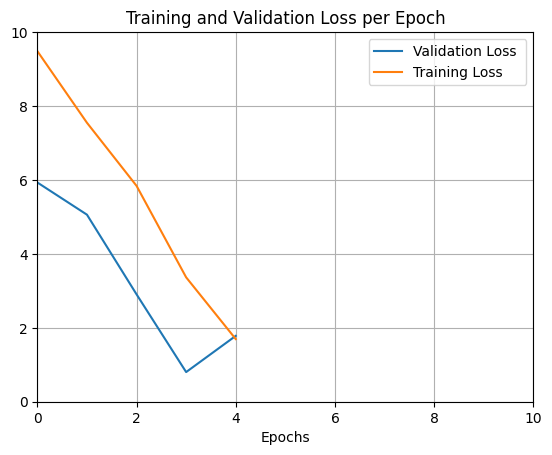

None

In [17]:
list_val_loss_all_epoch =[] 
list_train_loss_all_epoch =[]

for epoch in range(1, n_epochs+1):
    print('####### EPOCH ', epoch)
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    train_items = 0.0
    valid_items = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    print(' len(train_loader.dataset) = ', len(train_loader.dataset))
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        print('   train loss item = ', loss.item()*data.size(0))
        train_loss += loss.item()*data.size(0)
        train_items +=1
        
    ######################    
    # validate or evaluate the model #
    # To evaluate the model, it should be changed from model.train() to model.eval()
    ######################
    model.eval()
    print(' len(valid_loader.dataset) = ', len(valid_loader.dataset))
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        print('   valid loss item = ', loss.item()*data.size(0))
        valid_loss += loss.item()*data.size(0)
        valid_items +=1
    
    # calculate average losses
    print('\n train_loss = ', train_loss)
    print(' valid_loss = ', valid_loss)
    print('\n train_items = ', train_items)
    print(' valid_items = ', valid_items)
    #train_loss = train_loss/len(train_loader.dataset) # incorrect: this was averaging over 500 (the total amount of images available)
    #valid_loss = valid_loss/len(valid_loader.dataset)
    train_loss = train_loss/train_items # this is averaging correctly
    valid_loss = valid_loss/valid_items
    print('\n average train_loss = ', train_loss)
    print(' average valid_loss = ', valid_loss)

    list_val_loss_all_epoch.append(valid_loss)
    list_train_loss_all_epoch.append(train_loss)

    # print training/validation statistics 
    print('Epoch: {} \t Average Training Loss: {:.6f} \t Average Validation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))


    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

make_loss_graph(list_val_loss_all_epoch, list_train_loss_all_epoch)

In [18]:
#######################################################
# Analysis of the Model
# plotting loss and accuracy over epochs to see how it changed over training
######################################################
print("\n ****************  START TEST ******************* ")
# plot the accuracy
# confusion matrix
# dont train for 700 epochs - do for less ~20

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
i=1
# iterate over test data
len(test_loader)
for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
#     print(target)
    
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


 ****************  START TEST ******************* 
Test Loss: 0.081450

Test Accuracy of     0: 100% (56/56)
Test Accuracy of     1: 78% (44/56)

Test Accuracy (Overall): 89% (100/112)
